# Data Generator
Data Generator -> only load batches into GPU, not total dataset

In [1]:
import os
import pandas as pd
from copy import deepcopy
import numpy as np
import random
from tensorflow import keras
import tensorflow as tf

class ASLDataGenerator(keras.utils.Sequence):

    def __init__(self, dataset_path: str, max_phrase_length: int, max_sign_length: int, batch_size: int, train: bool = True):
        super().__init__()
        self.ds_path = dataset_path
        self.files = os.listdir(dataset_path)
        self.max_phrase_length = max_phrase_length
        self.max_sign_length = max_sign_length
        self.unwanted_columns = ['sequence_id', 'frame', 'participant_id', 'phrase']
        self.train = train
        self.batch_size = batch_size

    def __len__(self):
        return len(self.files)//self.batch_size

    def shuffle(self):
        random.shuffle(self.files)

    def on_epoch_end(self):
        if self.train:
            self.shuffle()

    def __getitem__(self, idx: int):
        batch_signs = []
        batch_contexts = []
        batch_phrases = []
        for i in range(idx, idx+self.batch_size):
            df_phrase = pd.read_pickle(self.ds_path + '/' + self.files[idx])
            phrase = df_phrase.iloc[0].phrase
            if len(phrase) > self.max_phrase_length-1:
                # check if phrase length longer than max_phrase_length
                print('Houston we have a problem!')

            # stop symbol is 61
            phrase.append(61)

            while len(phrase) < self.max_phrase_length:
                #padding value for remaining phrase is 59, to fill up missing phrase values until max_phrase_length
                phrase.append(59)

            context = deepcopy(phrase)
            # start symbol is 60
            context.insert(0, 60)
            context = context[:-1]

            df_phrase = df_phrase.drop(self.unwanted_columns, axis=1)
            signs = df_phrase.to_numpy(copy=True)

            if signs.shape[0] > self.max_sign_length:
                # check if length of sign data over max_sign_length
                print('Hooooouuuuusteeeeeen!')

            # fill up missing values of mediapipe data until max_sign_length with padding value 0
            signs = np.pad(signs, [(0, self.max_sign_length-signs.shape[0]), (0,0)], 'edge')
            batch_signs.append(signs)
            batch_contexts.append(context)
            batch_phrases.append(phrase)

        batch_signs = np.array(batch_signs)
        batch_contexts = np.array(batch_contexts)
        batch_phrases = np.array(batch_phrases)

        return [batch_signs, batch_contexts], batch_phrases

## Execute this cell for version with simple preprocessing (-1):

In [2]:
# Data with -1 as preprocessing
# get output from Data Generator
# for validation and test data we did a participant Wise Split!

MAX_PHRASE_LENGTH = 100  # experimentally determined untill no errors occured
MAX_SIGN_LENGTH = 900  # experimentally determined untill no errors occured
BATCH_SIZE= 32

data_gen_train = ASLDataGenerator('./dataset complete/preprocessed_files_data_generator/train_ones', MAX_PHRASE_LENGTH, MAX_SIGN_LENGTH, batch_size=BATCH_SIZE)
data_gen_train.shuffle()

data_gen_test = ASLDataGenerator('./dataset complete/preprocessed_files_data_generator/test_ones', MAX_PHRASE_LENGTH, MAX_SIGN_LENGTH, train=False, batch_size=BATCH_SIZE)

data_gen_val = ASLDataGenerator('./dataset complete/preprocessed_files_data_generator/val_ones', MAX_PHRASE_LENGTH, MAX_SIGN_LENGTH, train=False, batch_size=BATCH_SIZE)

In [3]:
# get input and phrase from one example of the output of the Data Generator, to later get shape
input, phrase = data_gen_train[0]

## Execute this cell for version with more complex preprocessing (mirroring):

In [4]:
# mirrored complex preprocessing data
# get output from Data generator

import tensorflow as tf
MAX_PHRASE_LENGTH = 100
MAX_SIGN_LENGTH = 900
BATCH_SIZE=32

data_gen_train = ASLDataGenerator('./dataset complete/preprocessed_files_data_generator/train', MAX_PHRASE_LENGTH, MAX_SIGN_LENGTH, batch_size=BATCH_SIZE)
data_gen_train.shuffle()

data_gen_test = ASLDataGenerator('./dataset complete/preprocessed_files_data_generator/test', MAX_PHRASE_LENGTH, MAX_SIGN_LENGTH, train=False, batch_size=BATCH_SIZE)

data_gen_val = ASLDataGenerator('./dataset complete/preprocessed_files_data_generator/validation_files', MAX_PHRASE_LENGTH, MAX_SIGN_LENGTH, train=False, batch_size=BATCH_SIZE)

In [ ]:
# get input and phrase from one example of the output of the Data Generator, to later get shape
input, phrase = data_gen_train[0]

# Train Transformer using Generator

In [4]:
# We used the Parameter values returned from the Hyperparameter tuning

import json

with open ("./dataset complete/character_to_prediction_index.json", "r") as f:
    characters = json.load(f)

# Tuned Hyperparameters
EPOCHS = 40
d_model = 141  # hidden layer(s) dimensionality
num_layers = 1 # how many encoders and decoders to stack
num_heads = 3 # how many attention heads should every mha have
ff_dim = 389 # how many neurons shall feed-forward layers have
dropout_rate = 0.2867

output_vocab_size = len(characters) + 3

In [5]:
output_vocab_size

62

In [5]:
from transformer_update import get_compiled_transformer

transformer = get_compiled_transformer(
    sign_shape=(MAX_SIGN_LENGTH, input[0].shape[-1]),
    context_shape=(input[1].shape[-1]),
    d_model=d_model,
    num_layers=num_layers,
    num_heads=num_heads,
    ff_dim=ff_dim,
    dropout_rate=dropout_rate,
    output_vocab_size=output_vocab_size
)

In [7]:
transformer.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 900, 144)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 100)]        0           []                               
                                                                                                  
 transformer (Transformer)      (None, 100, 62)      979803      ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
Total params: 979,803
Trainable params: 979,803
Non-trainable params: 0
______________________

In [8]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [6]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="model_checkpoints/cp-{epoch:04d}.ckpt", save_weights_only=True, verbose=1
)
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)
#shuffle_callback = ShuffleCallback()

history = transformer.fit(data_gen_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=data_gen_val, callbacks=[cp_callback, es_callback])

transformer.evaluate(data_gen_test, batch_size=BATCH_SIZE)

Epoch 1/40
2394/2394 [==============================] - ETA: 0s - loss: 3.0283 - masked_accuracy: 0.1593
Epoch 1: saving model to model_checkpoints\cp-0001.ckpt
2394/2394 [==============================] - 240s 99ms/step - loss: 3.0283 - masked_accuracy: 0.1593 - val_loss: 2.5257 - val_masked_accuracy: 0.2330
Epoch 2/40
2394/2394 [==============================] - ETA: 0s - loss: 2.6653 - masked_accuracy: 0.2088
Epoch 2: saving model to model_checkpoints\cp-0002.ckpt
2394/2394 [==============================] - 236s 99ms/step - loss: 2.6653 - masked_accuracy: 0.2088 - val_loss: 2.4890 - val_masked_accuracy: 0.2696
Epoch 3/40
2394/2394 [==============================] - ETA: 0s - loss: 2.5596 - masked_accuracy: 0.2384
Epoch 3: saving model to model_checkpoints\cp-0003.ckpt
2394/2394 [==============================] - 237s 99ms/step - loss: 2.5596 - masked_accuracy: 0.2384 - val_loss: 2.3701 - val_masked_accuracy: 0.2870
Epoch 4/40
2394/2394 [==============================] - ETA: 0s - l

[1.600693702697754, 0.5128329992294312]

In [7]:
# saving weights to file, so we can integrate these in the python server of our application
transformer.save_weights('./savedModelWeights/savedModelWeights')

In [11]:
restored = get_compiled_transformer(
    sign_shape=(MAX_SIGN_LENGTH, input[0].shape[-1]),
    context_shape=(input[1].shape[-1]),
    d_model=d_model,
    num_layers=num_layers,
    num_heads=num_heads,
    ff_dim=ff_dim,
    dropout_rate=dropout_rate,
    output_vocab_size=output_vocab_size
)

restored.load_weights('./savedModelWeights')

## Show Plots for Training history
Saved history to file to be able to display plots with upgraded matplotlib version

In [16]:
print(history.history.keys())

dict_keys(['loss', 'masked_accuracy', 'val_loss', 'val_masked_accuracy'])


In [27]:
import pickle

# Saved the history to a file using pickle
with open("training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

In [ ]:
import pickle

# Load the history from the file
with open("training_history.pkl", "rb") as f:
    loaded_history = pickle.load(f)
loaded_history

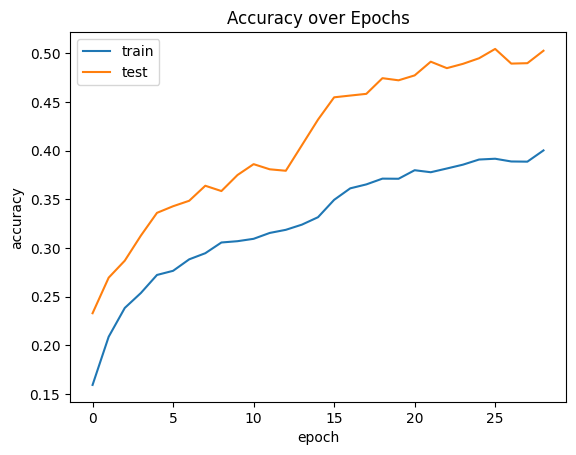

In [3]:
import matplotlib.pyplot as plt

plt.plot(loaded_history['masked_accuracy'])
plt.plot(loaded_history['val_masked_accuracy'])
plt.title('Accuracy over Epochs')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

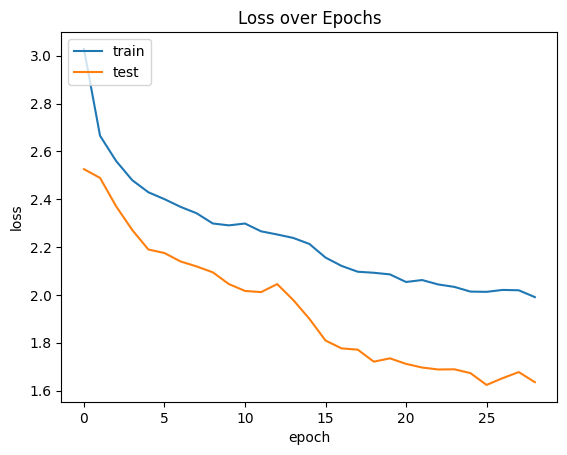

In [4]:
plt.plot(loaded_history['loss'])
plt.plot(loaded_history['val_loss'])
plt.title('Loss over Epochs')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Translate
Test prediction and translation in Python, however only test data from Google available

In [8]:
#test Translation within Python, however again based on test dataset

import tensorflow as tf
import numpy as np
from copy import deepcopy

MAX_PHRASE_LENGTH = 100

class Translator:
    def __init__(self, transformer):
        self.transformer = transformer

    def translate(self, signs, max_length=MAX_PHRASE_LENGTH):
        print(signs.shape)
        signs = tf.convert_to_tensor(signs, dtype=tf.float32, name='input_1')
        signs = signs[tf.newaxis]

        start = np.array([60])
        end = np.array([59])

        output = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
        output = output.write(0, start)

        for i in tf.range(max_length):
            context = deepcopy(output)
            while context.size() < 100:
                context = context.write(context.size(), end)
            context = tf.transpose(context.stack())
            context = tf.identity(context, name='input_2')
            predictions = self.transformer([signs, context], training=False)

            predictions = predictions[:, -1:, :]
            predicted = tf.argmax(predictions, axis=-1)
            output = output.write(i+1, predicted[0])

            if predicted == end:
                break

        output_tensor = output.stack()  # Convert TensorArray to tensor
        output_array = output_tensor.numpy()  # Convert tensor to NumPy array

        return output_array

In [2]:
transformer = tf.saved_model.load('./savedModel')

In [9]:
translator = Translator(transformer)

In [23]:
output = translator.translate(input[0][0], MAX_PHRASE_LENGTH)
print(output)

(900, 144)
[[60]
 [51]
 [51]
 [51]
 [51]
 [51]
 [51]
 [51]
 [51]
 [51]
 [51]
 [51]
 [51]
 [51]
 [51]
 [51]
 [51]
 [51]
 [51]
 [51]
 [51]
 [51]
 [51]
 [51]
 [51]
 [51]
 [51]
 [51]
 [51]
 [51]
 [51]
 [51]
 [51]
 [51]
 [51]
 [51]
 [51]
 [51]
 [51]
 [51]
 [51]
 [51]
 [46]
 [46]
 [46]
 [46]
 [46]
 [46]
 [46]
 [39]
 [51]
 [51]
 [51]
 [51]
 [51]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [36]
 [ 0]]


In [20]:
phrase

array([[33, 49, 32, ..., 59, 59, 59],
       [33, 49, 32, ..., 59, 59, 59],
       [33, 49, 32, ..., 59, 59, 59],
       ...,
       [33, 49, 32, ..., 59, 59, 59],
       [33, 49, 32, ..., 59, 59, 59],
       [33, 49, 32, ..., 59, 59, 59]])